# Kobe Bryant Shot Selection


#### The idea is taken from the Kaggle competition : 
#### https://www.kaggle.com/c/kobe-bryant-shot-selection

#### I will use this data to train a predictor on Kobe Bryant shoots

## 1. Import libraries and data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.misc import imread #enables the notebook to read images

In [9]:
%matplotlib inline 

sns.set_style("white") #set white background for seaborn plots

In [10]:
url = "/home/jo/github/Kobe/data/kobedata.csv"
df_data_with_nan = pd.read_csv(url)
df_data = df_data_with_nan.dropna(subset=['shot_made_flag']).reset_index(drop=True) #remove unusable data and reset indices

## 2. Exploring the data

In [11]:
df_data.columns.values

array(['action_type', 'combined_shot_type', 'game_event_id', 'game_id',
       'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'season', 'seconds_remaining', 'shot_distance',
       'shot_made_flag', 'shot_type', 'shot_zone_area', 'shot_zone_basic',
       'shot_zone_range', 'team_id', 'team_name', 'game_date', 'matchup',
       'opponent', 'shot_id'], dtype=object)

In [12]:
len(df_data), df_data.shape

(25697, (25697, 25))

In [13]:
df_data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
1,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
2,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
3,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
4,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


Quick check on most frequent shoots

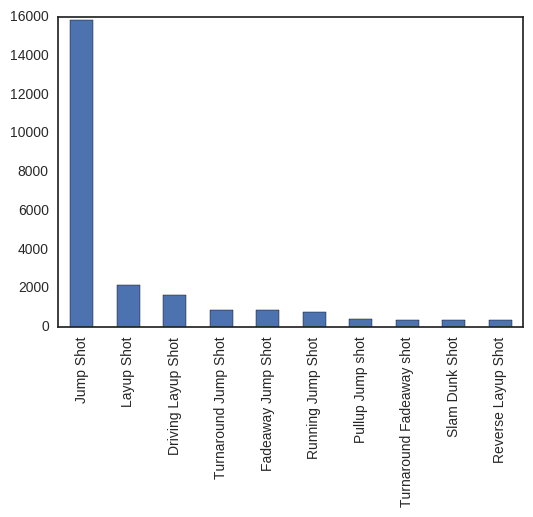

In [14]:
df_data['action_type'].value_counts()[:10].plot(kind='bar');

Quick check on frequent opponents.

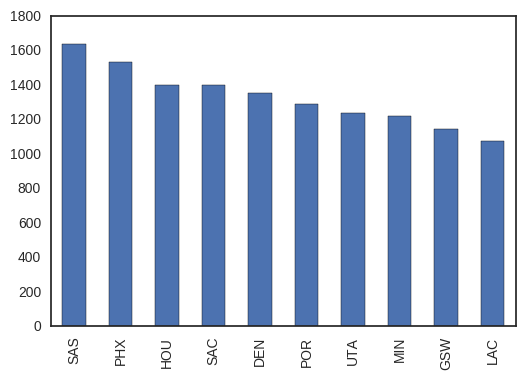

In [15]:
df_data['opponent'].value_counts()[:10].plot(kind='bar');

Ploting the ration of made/failed shots on some particular games

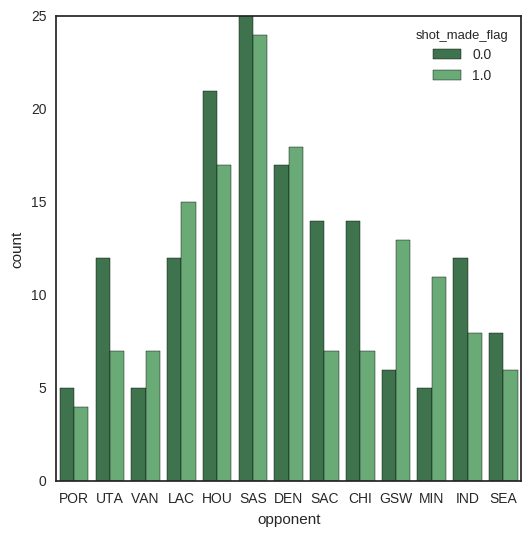

In [16]:
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set figure sizes
sns.countplot(x='opponent', hue='shot_made_flag', data=df_data[:300], palette='Greens_d');

A NBA Basketball half-court is 47' vs 50'. The 0 position is located 4' after the baseline
(source : https://upload.wikimedia.org/wikipedia/commons/6/6c/Basketball_courts.svg ).
So now we can plot the shots positions and add the court as a background image.

To save readability of the picture let's plot only shots against Los Angeles Clippers.

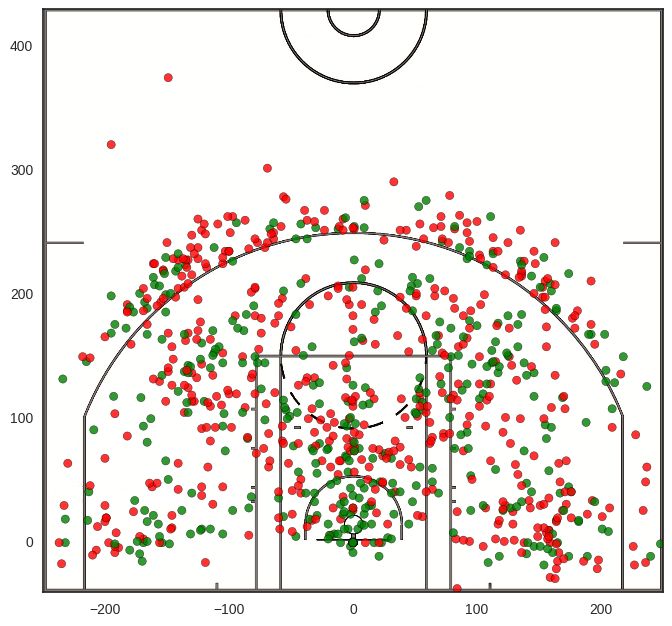

In [17]:
team_cond = df_data['opponent']=='LAC'

colors = {1.0:'green',0.0:'red'}
img = imread("img/nba_court_dimensions.jpg")

plt.rcParams['figure.figsize'] = (8.0, 10.0) # set figure sizes

plt.scatter(\
            df_data[team_cond]["loc_x"],\
            df_data[team_cond]["loc_y"],\
            c=df_data[team_cond]["shot_made_flag"].apply(lambda x: colors[x]),\
            zorder=1, alpha=0.8, s=35)#s defines size
plt.imshow(img, zorder=0, extent=[-250, 250, -40, 430]) #Use the extent keyword of imshow. The order of the argument is [left, right, bottom, top]

plt.show()

#### Now that we better understand the data we have, we can start building a  predictive model to guess whether or not Bryant scored his shot.

#### To do so, we will train different models like Logisitc Regression, SVM or Nearest Neighbors. Increasing at each step the features ingeneering and later the methodology. Logisitc Regression, SVM or Nearest Neighbors are probably not the best models for our problem, but once we'll be comfortable with them will move to better ones.
(Who said trees?)

#### The first step is to split the data we have to determine a training set and a test set. We will later optimize our methodology by using features selection and hyper-parameters tuning with Cross Validation (K-Fold).

#### Depending on the application of our algorithm we should define a test set specificaly. For example, if we want to predict all the shots of the next game, we should take a test set of events that always occur after the training set; and never consider future events.

#### In this case, we will take a simplified approach, we will just try to guess if one random shoot was sinked, considering any other shoot. So we can split sets randomly.

In [18]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn import cross_validation as cv
from sklearn import svm
from sklearn import neighbors, datasets

In [22]:
def train_log_reg(train_X,train_Y,test_X,test_Y):
    """ Train logistic regression and return:
        * regression details
        * fpr
        * tpr
    """
    reg = linear_model.LogisticRegression()
    reg.fit(train_X, train_Y)

    predictions = reg.predict_proba(test_X)[:, 1]

    fpr, tpr, _ = metrics.roc_curve(test_Y, predictions)
    
    
    return reg, fpr, tpr

In [20]:
def train_svm(train_X,train_Y,test_X,test_Y):
    """ Train a support vector machine and return:
        * regression details
        * fpr
        * tpr
    """
    
    reg = svm.LinearSVC()
    reg.fit(train_X, train_Y)

    predictions = reg.predict(test_X)

    fpr, tpr, _ = metrics.roc_curve(test_Y, predictions)
    
    
    return reg, fpr, tpr

In [21]:
def train_knn(train_X,train_Y,test_X,test_Y,n_neighbors):
    """ Train a nearest neighbours model and return:
        * regression details
        * fpr
        * tpr
    """

    reg = neighbors.KNeighborsClassifier(n_neighbors,weights='distance')
    reg.fit(train_X, train_Y)

    predictions = reg.predict(test_X)

    fpr, tpr, _ = metrics.roc_curve(test_Y, predictions)
    
    
    return reg, fpr, tpr

### For the first scenario, we will only use the X,Y position of the shoot as input features for our models. Don't expect too much about it.

In [28]:
#Define Labels and features
le = preprocessing.LabelEncoder()
Y = le.fit_transform(df_data["shot_made_flag"].values)
X = df_data[["loc_x","loc_y"]]

In [29]:
#Randomly split train and test sets
train_X, test_X, train_Y, test_Y = cv.train_test_split(X,Y, test_size=0.3, random_state=0)

#### Logistic Regression

In [41]:
reg , fpr, tpr = train_log_reg(train_X,train_Y,test_X,test_Y)
auc_metric = metrics.auc(fpr, tpr)
print "AUC of Logistic Regression: {0}".format(auc_metric)

AUC of Logistic Regression: 0.580517113087


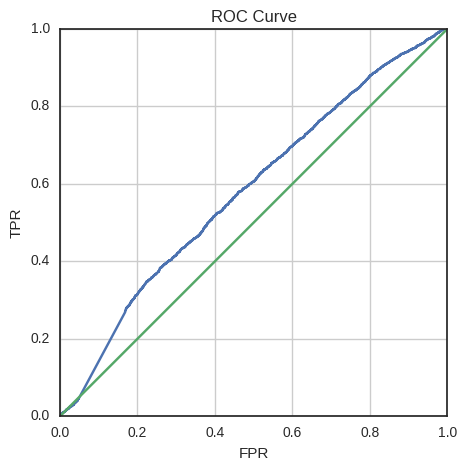

In [42]:
#Let's plot the ROC Curve for once
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.plot(fpr, tpr)
plt.plot(np.linspace(0.0, 1.0, 100),np.linspace(0.0, 1.0, 100))
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid();

#### Let's visualize this on the court!

In [43]:
x_min= -250
x_max= 250
y_min= -40
y_max= 430

nb_X_points=(x_max-x_min)/10 #50 points
nb_Y_points=(y_max-y_min)/10 #47 points

loc_x = np.linspace(x_min,x_max,nb_X_points) 
loc_y = np.linspace(y_min,y_max,nb_Y_points) 

all_X = np.tile(loc_x, nb_Y_points)
all_Y = np.repeat(loc_y, nb_X_points)
all_court = np.transpose([all_X, all_Y])

predictions_on_court = reg.predict_proba(all_court)[:, 1].reshape((nb_Y_points, nb_X_points))

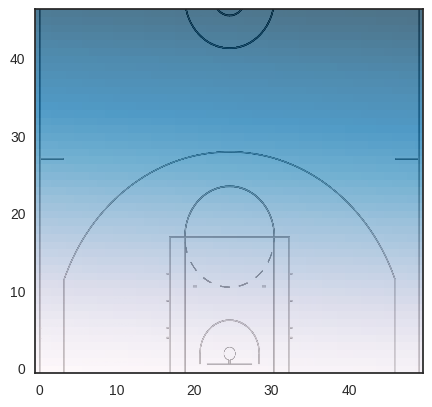

In [44]:
from matplotlib import cm

plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.imshow(img, zorder=0, extent=[0, 49, -4, 48])
plt.imshow(predictions_on_court, interpolation='None', cmap='PuBu_r', alpha=0.7,origin='lower');

Bryant had basicaly no chance to score in the blue zone, and is supposed to have great results in the white one... at least according to this model... with 58% AUC.

Note that the X position is not relevant here, which is obviously wrong. It's much more difficult to score from the bottom left corner, than from under the ring.

#### Nearest Neighbors

In [34]:
reg , fpr, tpr = train_knn(train_X,train_Y,test_X,test_Y,20)
auc_metric = metrics.auc(fpr, tpr)
print "AUC of KNN : {0}".format(auc_metric)

AUC of KNN : 0.556011068375


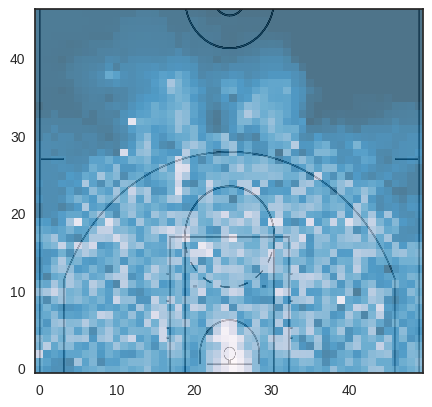

In [40]:
from matplotlib import cm

plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.imshow(img, zorder=0, extent=[0, 49, -4, 48])
plt.imshow(predictions_on_court, interpolation='None', cmap='PuBu_r', alpha=0.7,origin='lower');

KNN gives a beautifull vizualisation so far, instead of beautifull results... :( 
We directly see that KNN is really overfitting here. (Do you see this white point far behind the 3PT line?)

#### SVM

In [45]:
reg , fpr, tpr = train_svm(train_X,train_Y,test_X,test_Y)
auc_metric = metrics.auc(fpr, tpr)
print "AUC of SVM : {0}".format(auc_metric)

AUC of SVM : 0.507912793845


We could fine-tune this terrible model a little, but the point is not to go deeper in SVM. Instead of a useless representation of the field, I prefer to leave you a beatifull bubble graph. I hope you prefer bubbles to AUC. ;)

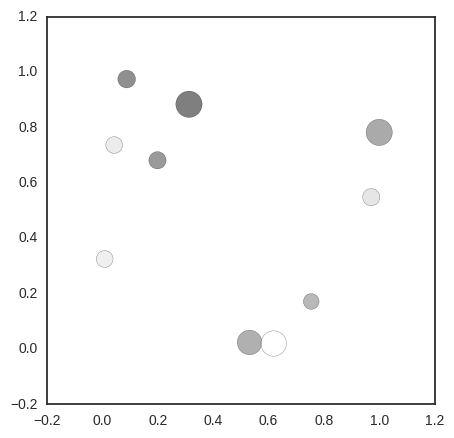

In [51]:
#Test Cell for matplotlib

import numpy as np
import matplotlib.pyplot as plt


N = 10
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = 40*(1+10*np.sin(np.random.rand(N)))

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

### Let's try to do a little bit better now with some feature engineering.

In [52]:
def polar_r(data):
    return np.sqrt(data["loc_x"]**2+data["loc_y"]**2)
     
def polar_theta(data):
    #we choose to have theta=0 when X=0
    return np.arctan2(-data["loc_x"],data["loc_y"])


In [53]:
data_polar = df_data[["loc_x","loc_y","shot_made_flag"]]

data_polar["r"]=df_data.apply(polar_r,axis=1)
data_polar["theta"] = df_data.apply(polar_theta,axis=1)

data_polar.head()

/home/jo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,loc_x,loc_y,shot_made_flag,r,theta
0,-157,0,0.0,157.000000,1.570796
1,-101,135,1.0,168.600119,0.642315
2,138,175,0.0,222.865430,-0.667733
3,0,0,1.0,0.000000,0.000000
4,-145,-11,0.0,145.416643,1.646513


Did you guess? 

Yes, we'll introduce polar coordinates to see if we can already do better.

And we'll directly try a model using the following features: X, Y, r, theta

In [61]:
#le = preprocessing.LabelEncoder()
#Y = le.fit_transform(data_polar["shot_made_flag"].values)
X = data_polar[["loc_x","loc_y","r","theta"]]

In [57]:
train_X, test_X, train_Y, test_Y = cv.train_test_split(X,Y, test_size=0.3, random_state=0)

#### Let's try again, a little of LogReg with some more interesting features

In [59]:
reg , fpr, tpr = train_log_reg(train_X,train_Y,test_X,test_Y)
auc_metric = metrics.auc(fpr, tpr)
print "AUC of Logistic Regression: {0}".format(auc_metric)

AUC of Logistic Regression: 0.603024545848


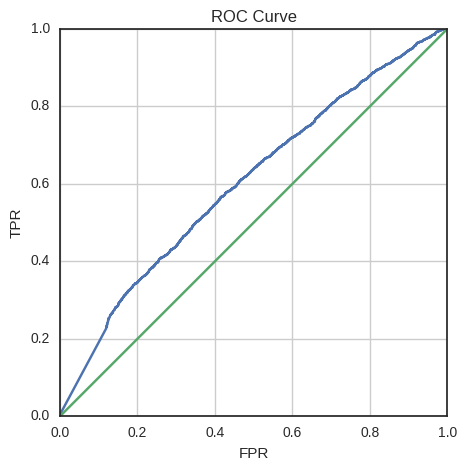

In [63]:
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.plot(fpr, tpr)
plt.plot(np.linspace(0.0, 1.0, 100),np.linspace(0.0, 1.0, 100))
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid();

#### And see what it gives on the court

In [64]:
def polar(position_xy):
    x,y = position_xy[0],position_xy[1]
    r = np.sqrt(x**2+y**2)
    theta = np.arctan2(-x,y)
    return r, theta

In [65]:
def posxy_to_posxyrtheta(position_xy):
    x,y = position_xy[0],position_xy[1]
    r, theta = polar(position_xy)
    return x,y,r,theta

In [66]:
x_min= -250
x_max= 250
y_min= -40
y_max= 430

nb_X_points=(x_max-x_min)/10 #50 points
nb_Y_points=(y_max-y_min)/10 #47 points

In [67]:
loc_x = np.linspace(x_min,x_max,nb_X_points) 
loc_y = np.linspace(y_min,y_max,nb_Y_points) 

all_X = np.tile(loc_x, nb_Y_points)
all_Y = np.repeat(loc_y, nb_X_points)

all_court = np.transpose([all_X, all_Y])
all_court_with_polar = np.apply_along_axis(posxy_to_posxyrtheta,1,all_court)

In [68]:
predictions_on_court = reg.predict_proba(all_court_with_polar)[:, 1].reshape((nb_Y_points, nb_X_points))

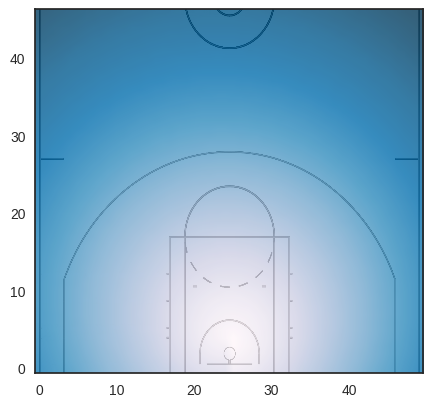

In [69]:
from matplotlib import cm

plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.imshow(img, zorder=0, extent=[0, 49, -4, 48])
plt.imshow(predictions_on_court, interpolation=None, cmap='PuBu_r', alpha=0.8,origin='lower');

Ok we are doing a bit better, but it's still not awesome. At least the visualization makes some sense. :)

#### Let's try to redo the same thing with feature scaling.

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
def train_logreg_scaled(train_X,train_Y,test_X,test_Y):
    
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    
    test_X = scaler.transform(test_X)
    
    reg = linear_model.LogisticRegression()
    reg.fit(train_X, train_Y)

    predictions = reg.predict_proba(test_X)[:, 1]

    fpr, tpr, _ = metrics.roc_curve(test_Y, predictions)
    
    
    return reg, fpr, tpr

In [74]:
#le = preprocessing.LabelEncoder()
#Y = le.fit_transform(data_polar["shot_made_flag"].values)
X = data_polar[["loc_x","loc_y","r","theta"]]

In [76]:
train_X, test_X, train_Y, test_Y = cv.train_test_split(X,Y, test_size=0.3, random_state=0)

In [77]:
_ , fpr, tpr = train_logreg_scaled(train_X,train_Y,test_X,test_Y)

auc_metric = metrics.auc(fpr, tpr)
print "AUC of Logistic Regression: {0}".format(auc_metric)


AUC of Logistic Regression: 0.603008549313


The impact of feature scaling seems pointless here!